# Problem Definition: Will we be Homeless?

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [4]:
# Load the dataset to understand its structure
file_path = 'Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_month.csv'
data = pd.read_csv(file_path)

# Display basic information about the dataset
data_info = {
    "Head": data.head(),
    "Info": data.info(),
    "Description": data.describe(include='all'),
    "Columns": data.columns.tolist(),
}

data_info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Columns: 352 entries, RegionID to 2024-12-31
dtypes: float64(347), int64(2), object(3)
memory usage: 2.4+ MB


{'Head':    RegionID  SizeRank       RegionName RegionType StateName     1996-02-29  \
 0    102001         0    United States    country       NaN  101974.243981   
 1    394913         1     New York, NY        msa        NY  178886.438765   
 2    753899         2  Los Angeles, CA        msa        CA  183979.711478   
 3    394463         3      Chicago, IL        msa        IL  129302.420536   
 4    394514         4       Dallas, TX        msa        TX  109454.091687   
 
       1996-03-31     1996-04-30     1996-05-31     1996-06-30  ...  \
 0  102232.420950  102779.727988  103524.018573  104327.643423  ...   
 1  178149.563306  177978.593540  178203.428078  179067.247633  ...   
 2  185116.621447  185977.073063  186341.801871  186979.330135  ...   
 3  128711.067254  130122.717229  131799.780985  133356.494598  ...   
 4  110129.928049  111180.303297  112027.708339  112534.276976  ...   
 
       2024-03-31     2024-04-30     2024-05-31     2024-06-30     2024-07-31  \
 0  352

# Data Wrangling
Clean the data in the following ways:

- Check for missing values
- Look for consistency of datatypes in all the columns
- Data description
- Data outliers in certain columns
- Visualization

In [8]:
# Check for missing values and their percentages
missing_values = data.isnull().sum()
missing_percentages = (missing_values / len(data)) * 100

# Filter columns with missing values and sort them
missing_summary = pd.DataFrame({
    "Missing Values": missing_values,
    "Percentage (%)": missing_percentages
}).query("`Missing Values` > 0").sort_values(by="Missing Values", ascending=False)

print("Missing Values Summary with Percentages:")
print(missing_summary)

# Check data types for consistency
datatypes_summary = data.dtypes.value_counts()
print("\nDatatype Consistency:")
print(datatypes_summary)

# Generate a statistical description of numeric columns
numeric_description = data.describe()
print("\nNumeric Data Description:")
print(numeric_description)

# Detect outliers in selected numeric columns using IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers.shape[0]

# Example: Checking outliers in the first few time series columns
time_series_columns = data.columns[5:]  # Assuming first 5 columns are metadata
outlier_counts = {col: detect_outliers(data, col) for col in time_series_columns[:10]}  # Check first 10 time columns

print("\nOutlier Counts (first 10 time columns):")
for col, count in outlier_counts.items():
    print(f"{col}: {count} outliers")


Missing Values Summary with Percentages:
            Missing Values  Percentage (%)
1996-02-29             464       51.843575
1996-03-31             463       51.731844
1996-04-30             462       51.620112
1996-05-31             460       51.396648
1996-06-30             458       51.173184
...                    ...             ...
2013-06-30               1        0.111732
2013-07-31               1        0.111732
2013-08-31               1        0.111732
2013-09-30               1        0.111732
2022-09-30               1        0.111732

[237 rows x 2 columns]

Datatype Consistency:
float64    347
object       3
int64        2
Name: count, dtype: int64

Numeric Data Description:
            RegionID    SizeRank     1996-02-29     1996-03-31     1996-04-30  \
count     895.000000  895.000000     431.000000     432.000000     433.000000   
mean   412099.672626  461.751955   89637.468543   89964.210427   90474.721408   
std     78377.355083  268.710532   36838.191549   36821

# Cleaning Data

In [11]:
# Separate numeric and categorical columns
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Impute numeric columns with the column mean
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Impute categorical columns with the mode (most frequent value)
for col in categorical_columns:
    data[col] = data[col].fillna(data[col].mode()[0])

# Check if there are any missing values left
missing_values_after = data.isnull().sum()
print("Missing Values After Imputation:")
print(missing_values_after[missing_values_after > 0])


# Filter data for San Jose, CA
san_jose_data = data[data["RegionName"] == "San Jose, CA"]

# Extract time series columns (assuming first 5 columns are metadata)
time_series_columns = data.columns[5:]
san_jose_ts = san_jose_data[time_series_columns].T.dropna()

# Convert index to datetime format for time series analysis
san_jose_ts.index = pd.to_datetime(san_jose_ts.index)
san_jose_ts.columns = ["ZHVI"]  # Rename for clarity

# Compute month-to-month differences to detect anomalies
san_jose_diff = san_jose_ts.diff()

# Define an outlier threshold (3 standard deviations below the mean)
outlier_threshold = san_jose_diff.mean() - (3 * san_jose_diff.std())

# Identify outliers (extreme sudden drops in values)
outliers = san_jose_diff[san_jose_diff < outlier_threshold].dropna()

# Display the outliers
outliers

# Replace detected outliers with interpolated values
san_jose_ts_cleaned = san_jose_ts.copy()

# Identify outlier indices
outlier_indices = outliers.index

# Interpolate only at the outlier points
san_jose_ts_cleaned.loc[outlier_indices] = None  # Set outliers to NaN
san_jose_ts_cleaned = san_jose_ts_cleaned.interpolate(method='linear')  # Apply linear interpolation

# Print the cleaned data to verify
print("San Jose ZHVI Data After Outlier Removal:")
print(san_jose_ts_cleaned.loc[outlier_indices])


Missing Values After Imputation:
Series([], dtype: int64)
San Jose ZHVI Data After Outlier Removal:
                    ZHVI
2022-09-30  1.450344e+06


# Data Analysis

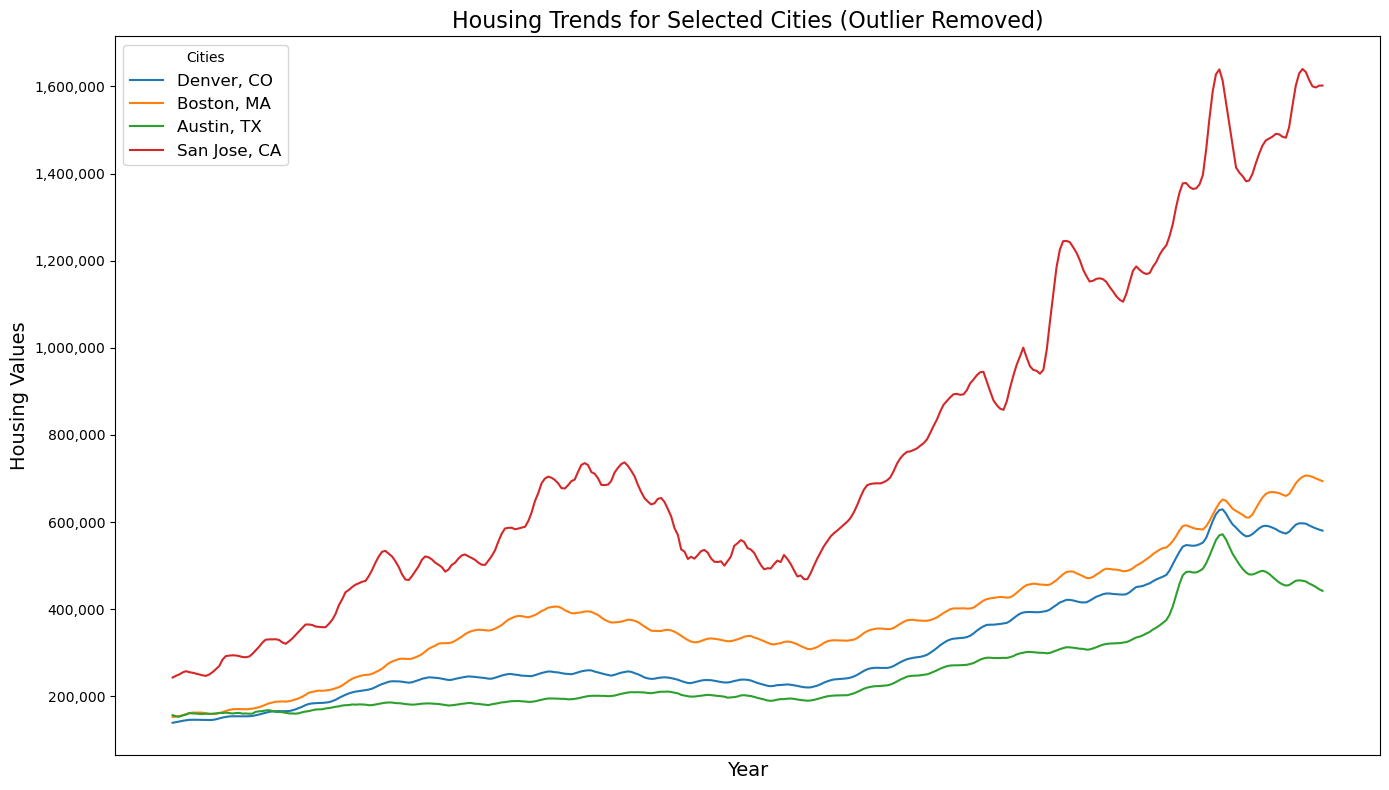

In [14]:
# Load dataset
file_path = "Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_month.csv"
data = pd.read_csv(file_path)

# Filter the data for the four selected cities
selected_cities = ["Denver, CO", "Boston, MA", "Austin, TX", "San Jose, CA"]
city_data = data[data["RegionName"].isin(selected_cities)]

# Extract time series columns (assuming first 5 columns are metadata)
time_series_columns = data.columns[5:]
city_trends = city_data[["RegionName"] + list(time_series_columns)].set_index("RegionName").T
city_trends.index = pd.to_datetime(city_trends.index)

# Fix outlier in San Jose
san_jose_data = city_trends["San Jose, CA"].copy()
san_jose_diff = san_jose_data.diff()

# Define an outlier threshold (3 standard deviations below the mean)
outlier_threshold = san_jose_diff.mean() - (3 * san_jose_diff.std())

# Identify outliers
outliers = san_jose_diff[san_jose_diff < outlier_threshold].dropna()

# Remove outliers using interpolation
san_jose_data.loc[outliers.index] = None  # Set outliers to NaN
san_jose_data = san_jose_data.interpolate(method="linear")  # Apply linear interpolation

# Update city trends with cleaned San Jose data
city_trends["San Jose, CA"] = san_jose_data

# Plot the updated trends for the selected cities
plt.figure(figsize=(14, 8))
for city in selected_cities:
    plt.plot(city_trends.index, city_trends[city], label=city)

# Customize the y-axis to remove scientific notation
plt.ticklabel_format(style="plain", axis="y")
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Customize the x-axis to show years only
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(365 * 24 * 60 * 60))  # Show yearly ticks
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: pd.to_datetime(x, unit="s").strftime("%Y")))

plt.title("Housing Trends for Selected Cities (Outlier Removed)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Housing Values", fontsize=14)
plt.legend(title="Cities", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the updated plot
plt.show()




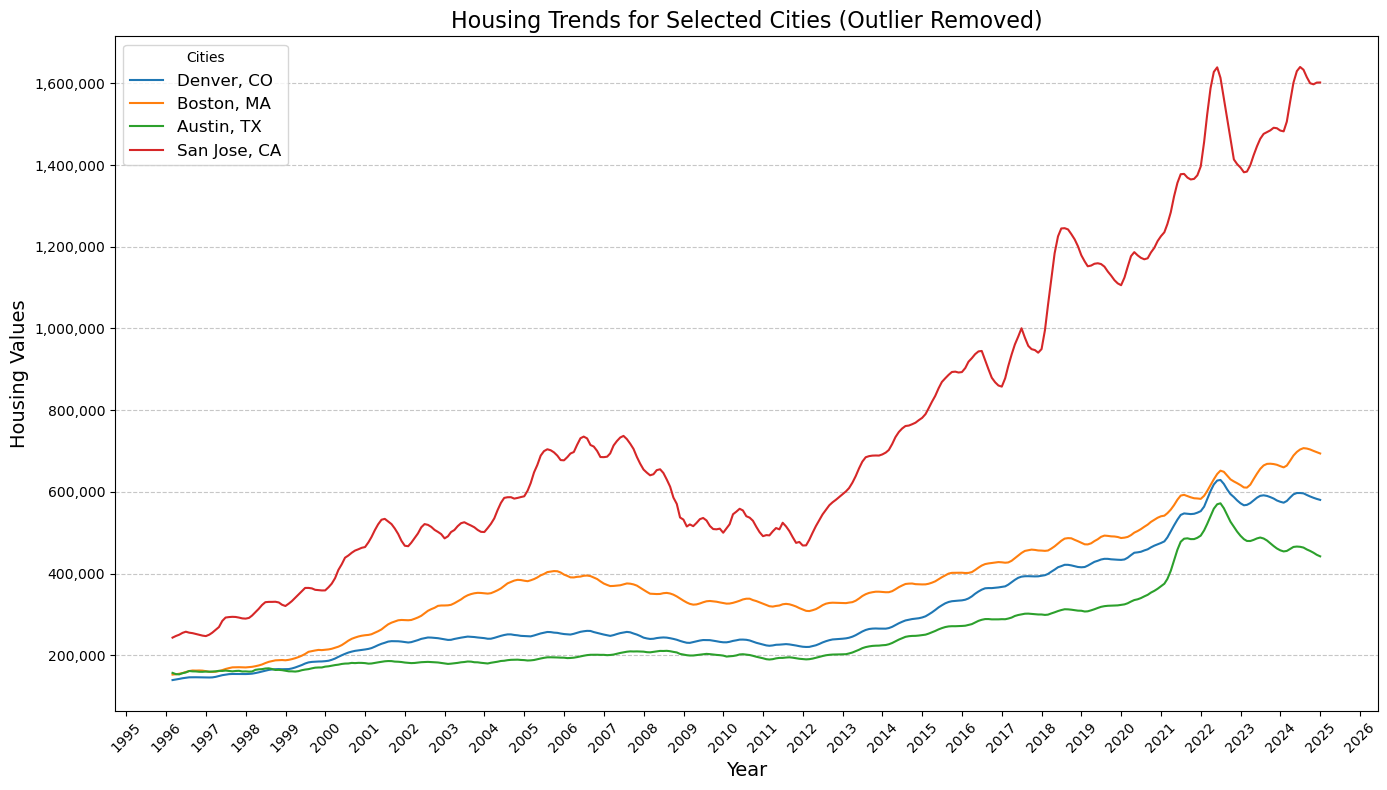

In [16]:
# Update x-axis formatting to properly display year labels
import matplotlib.dates as mdates

# Plot the updated trends for the selected cities
plt.figure(figsize=(14, 8))
for city in selected_cities:
    plt.plot(city_trends.index, city_trends[city], label=city)

# Customize the y-axis to remove scientific notation
plt.ticklabel_format(style="plain", axis="y")
plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Set x-axis to show only yearly intervals
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Show labels every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Format as YYYY

plt.title("Housing Trends for Selected Cities (Outlier Removed)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Housing Values", fontsize=14)
plt.legend(title="Cities", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the updated plot with readable year labels
plt.show()


# Forecasting using Holt-Winters Exponential Smoothing Model

C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\nikhi\AppData\Local\Temp\ipykernel_34304\1460389031.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=city_forecast_data.index[-1], periods=forecast_periods + 1, freq='M')[1:]


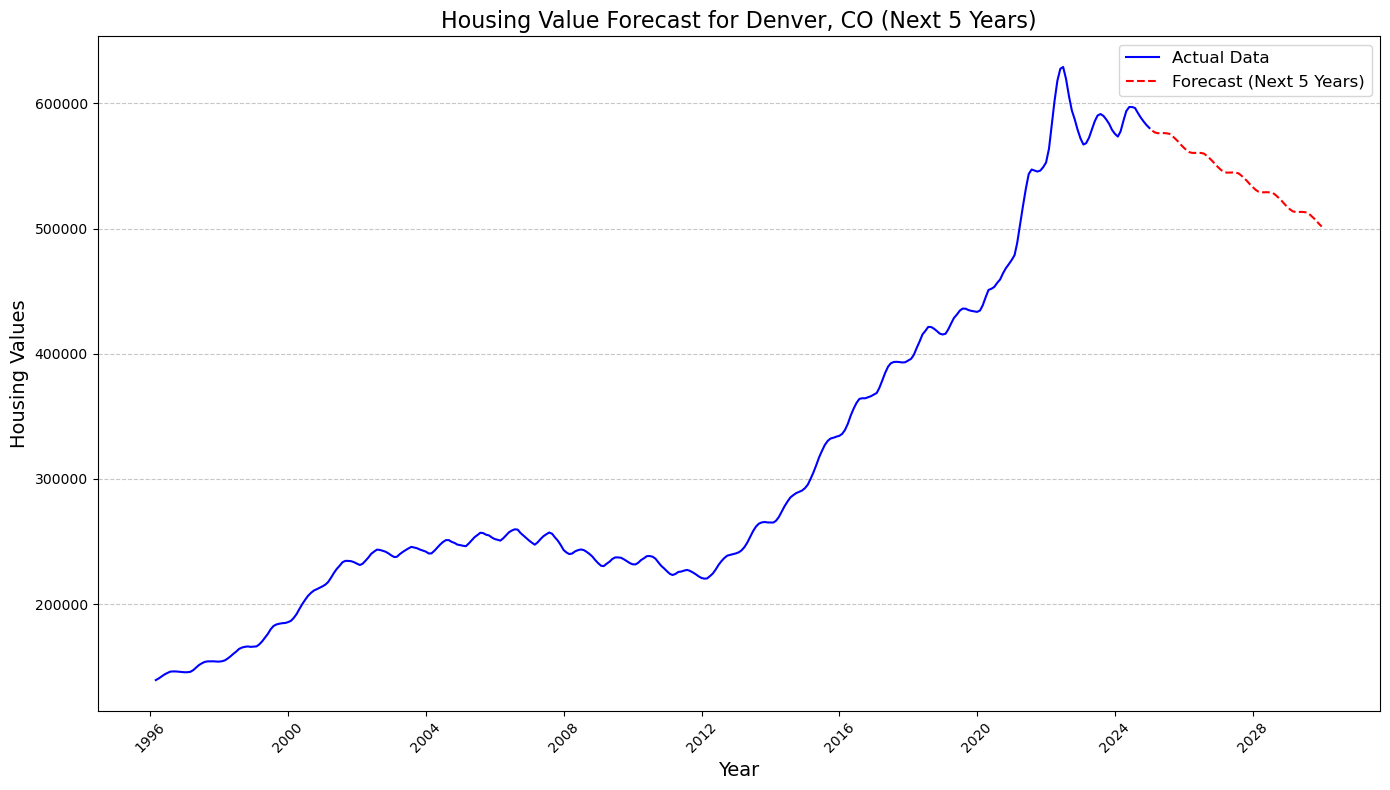

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Select a city for forecasting (e.g., Denver, CO). You can change this to any city.
forecast_city = "Denver, CO"
city_forecast_data = city_trends[forecast_city].dropna()

# Convert index to datetime format
city_forecast_data.index = pd.to_datetime(city_forecast_data.index)

# Define the forecast period (next 5 years)
forecast_periods = 5 * 12  # 5 years * 12 months

# Fit the Holt-Winters Exponential Smoothing model
model = ExponentialSmoothing(
    city_forecast_data, 
    trend="add", 
    seasonal="add", 
    seasonal_periods=12
)
fitted_model = model.fit()

# Generate forecast for the next 5 years
forecast_index = pd.date_range(start=city_forecast_data.index[-1], periods=forecast_periods + 1, freq='M')[1:]
forecast_values = fitted_model.forecast(steps=forecast_periods)

# Plot the actual values and forecasted values
plt.figure(figsize=(14, 8))
plt.plot(city_forecast_data.index, city_forecast_data, label="Actual Data", color="blue")
plt.plot(forecast_index, forecast_values, label="Forecast (Next 5 Years)", color="red", linestyle="dashed")

# Formatting the plot
plt.title(f"Housing Value Forecast for {forecast_city} (Next 5 Years)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Housing Values", fontsize=14)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\nikhi\AppData\Local\Temp\ipykernel_34304\3445697809.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=city_forecast_data.index[-1], periods=periods + 1, freq='M')[1:]


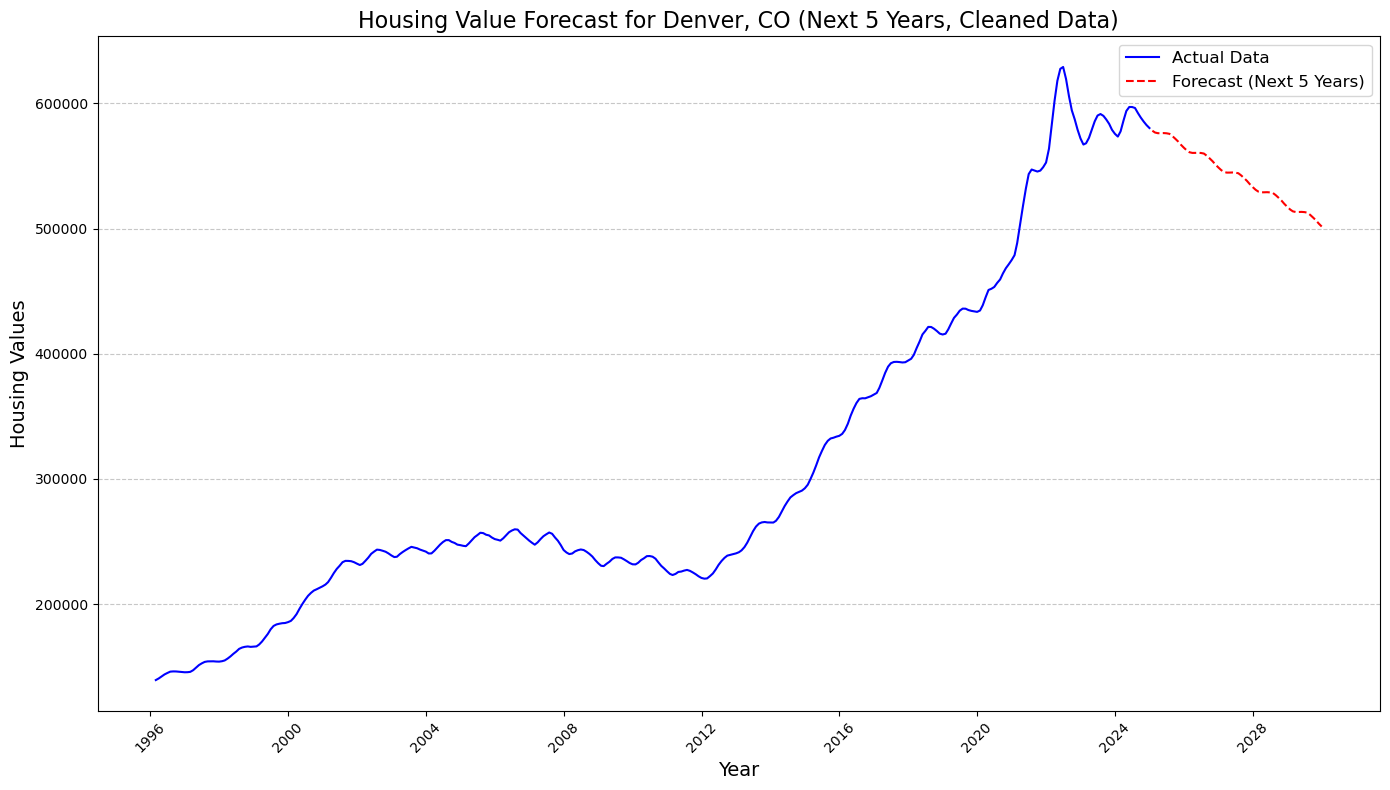

C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\nikhi\AppData\Local\Temp\ipykernel_34304\3445697809.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=city_forecast_data.index[-1], periods=periods + 1, freq='M')[1:]


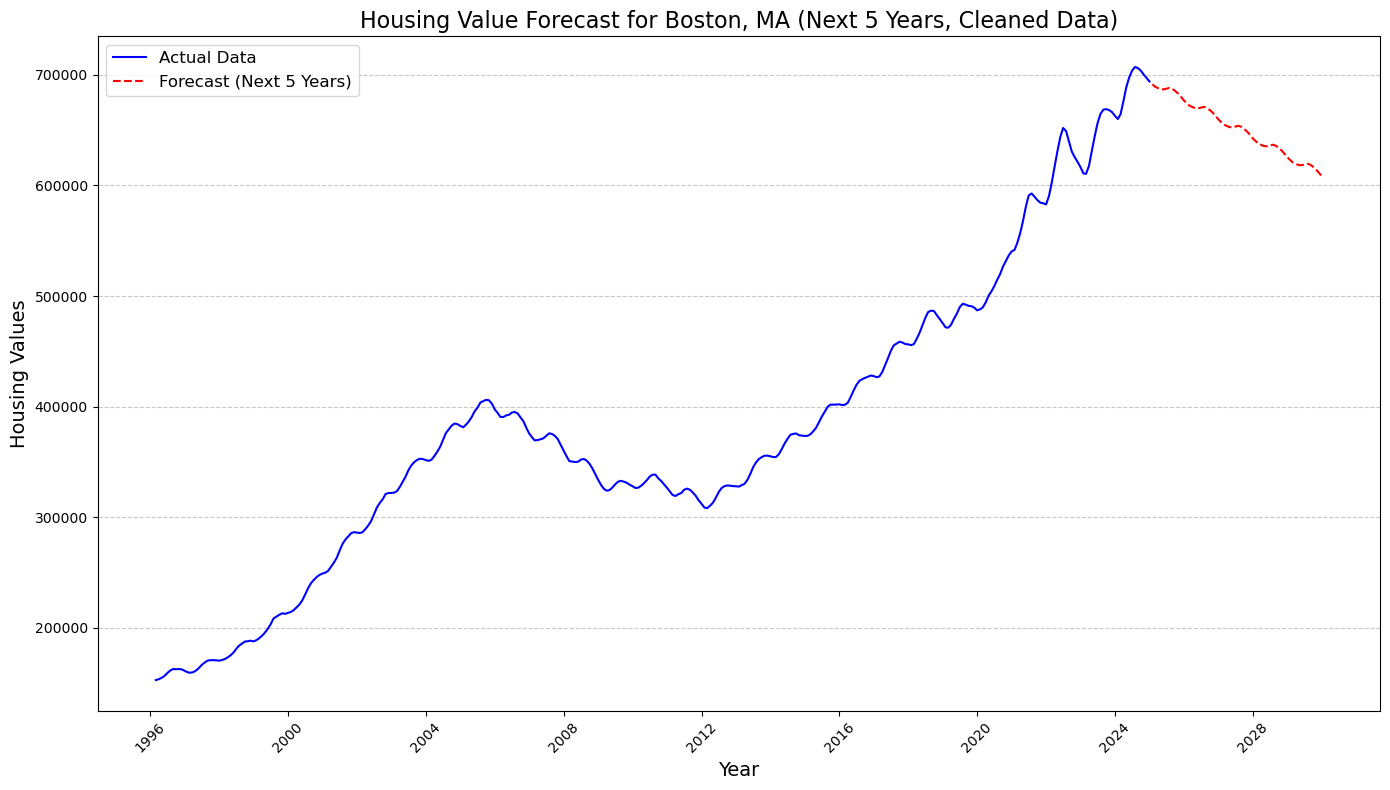

C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\nikhi\AppData\Local\Temp\ipykernel_34304\3445697809.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=city_forecast_data.index[-1], periods=periods + 1, freq='M')[1:]


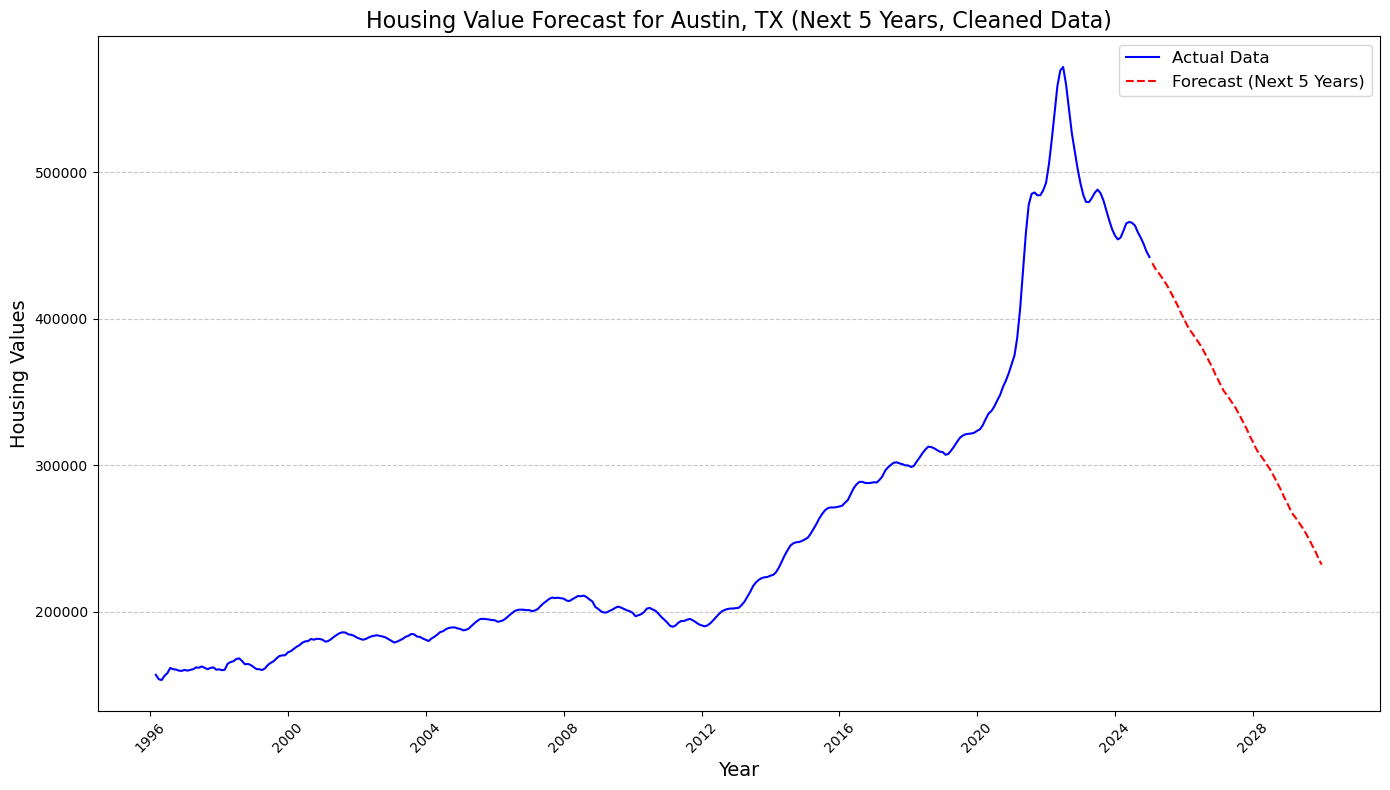

C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\nikhi\AppData\Local\Temp\ipykernel_34304\3445697809.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=city_forecast_data.index[-1], periods=periods + 1, freq='M')[1:]


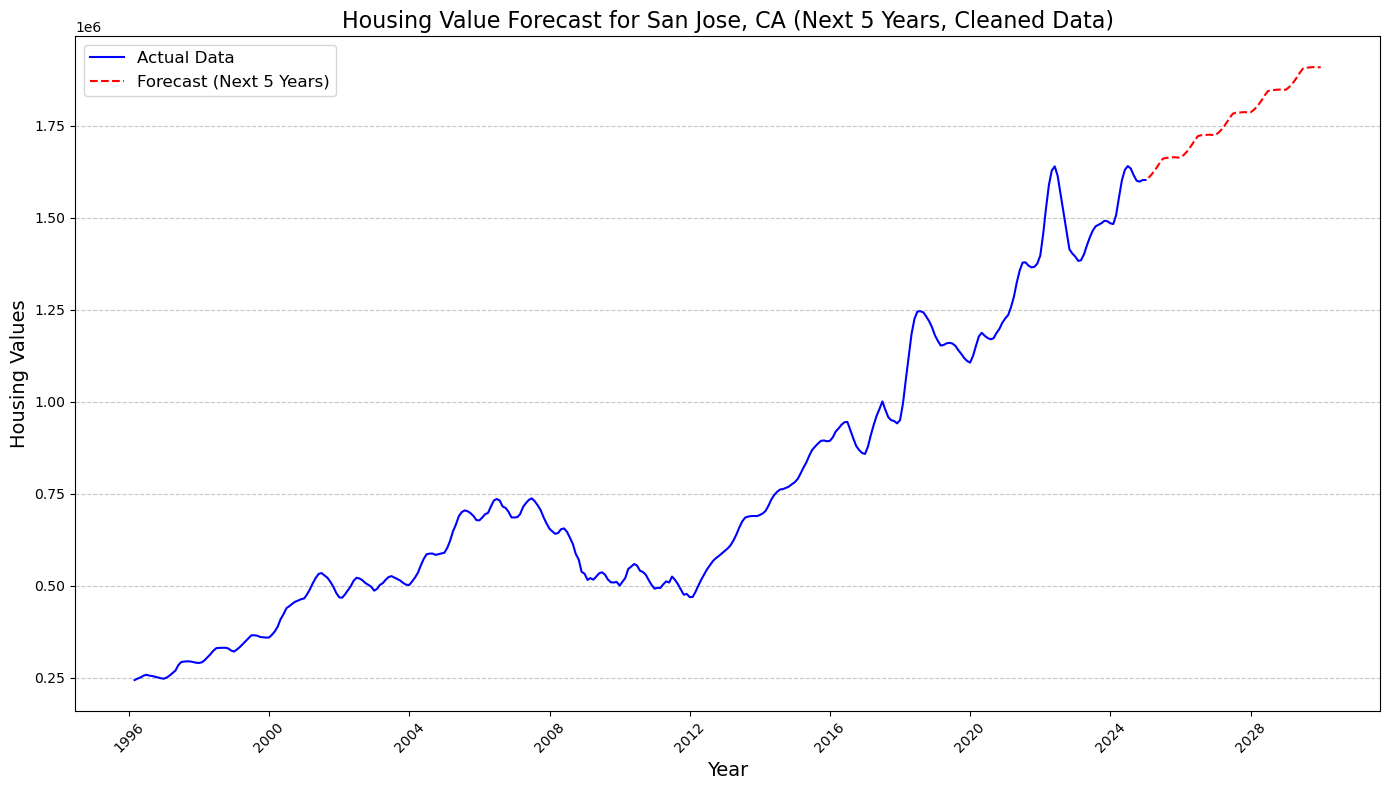

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Define a function to forecast housing values for a given city (with San Jose's outlier removed)
def forecast_housing_values_cleaned(city_name, periods=5 * 12):  # Forecast for 5 years (monthly data)
    city_forecast_data = city_trends[city_name].dropna()

    # Convert index to datetime format
    city_forecast_data.index = pd.to_datetime(city_forecast_data.index)

    # Fit the Holt-Winters Exponential Smoothing model
    model = ExponentialSmoothing(
        city_forecast_data, 
        trend="add", 
        seasonal="add", 
        seasonal_periods=12
    )
    fitted_model = model.fit()

    # Generate forecast for the next 5 years
    forecast_index = pd.date_range(start=city_forecast_data.index[-1], periods=periods + 1, freq='M')[1:]
    forecast_values = fitted_model.forecast(steps=periods)

    # Plot the actual values and forecasted values
    plt.figure(figsize=(14, 8))
    plt.plot(city_forecast_data.index, city_forecast_data, label="Actual Data", color="blue")
    plt.plot(forecast_index, forecast_values, label="Forecast (Next 5 Years)", color="red", linestyle="dashed")

    # Formatting the plot
    plt.title(f"Housing Value Forecast for {city_name} (Next 5 Years, Cleaned Data)", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Housing Values", fontsize=14)
    plt.legend(fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Ensure San Jose's data is cleaned before forecasting
san_jose_cleaned = city_trends["San Jose, CA"].copy()
san_jose_cleaned.loc[outliers.index] = None  # Set outliers to NaN
san_jose_cleaned = san_jose_cleaned.interpolate(method="linear")  # Apply linear interpolation

# Update city trends with cleaned San Jose data
city_trends["San Jose, CA"] = san_jose_cleaned

# Forecast for each city one by one using cleaned data
for city in selected_cities:
    forecast_housing_values_cleaned(city)



# Forecasting using Auto ARIMA

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6570.414, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6629.743, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6565.755, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6570.118, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6671.218, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=6571.933, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=6560.820, Time=0.91 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=6546.590, Time=1.35 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=6545.125, Time=0.49 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=6569.334, Time=0.29 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=6546.564, Time=1.34 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=6565.371, Time=0.79 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.57 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=6613.558, Time=0.15 sec
 ARIMA(2,1,0)(1,0,1)[12]

C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\AppData\Local\Temp\ipykernel_34304\1133722841.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=city_forecast_data.index[-1], periods=periods + 1, freq='M')[1:]


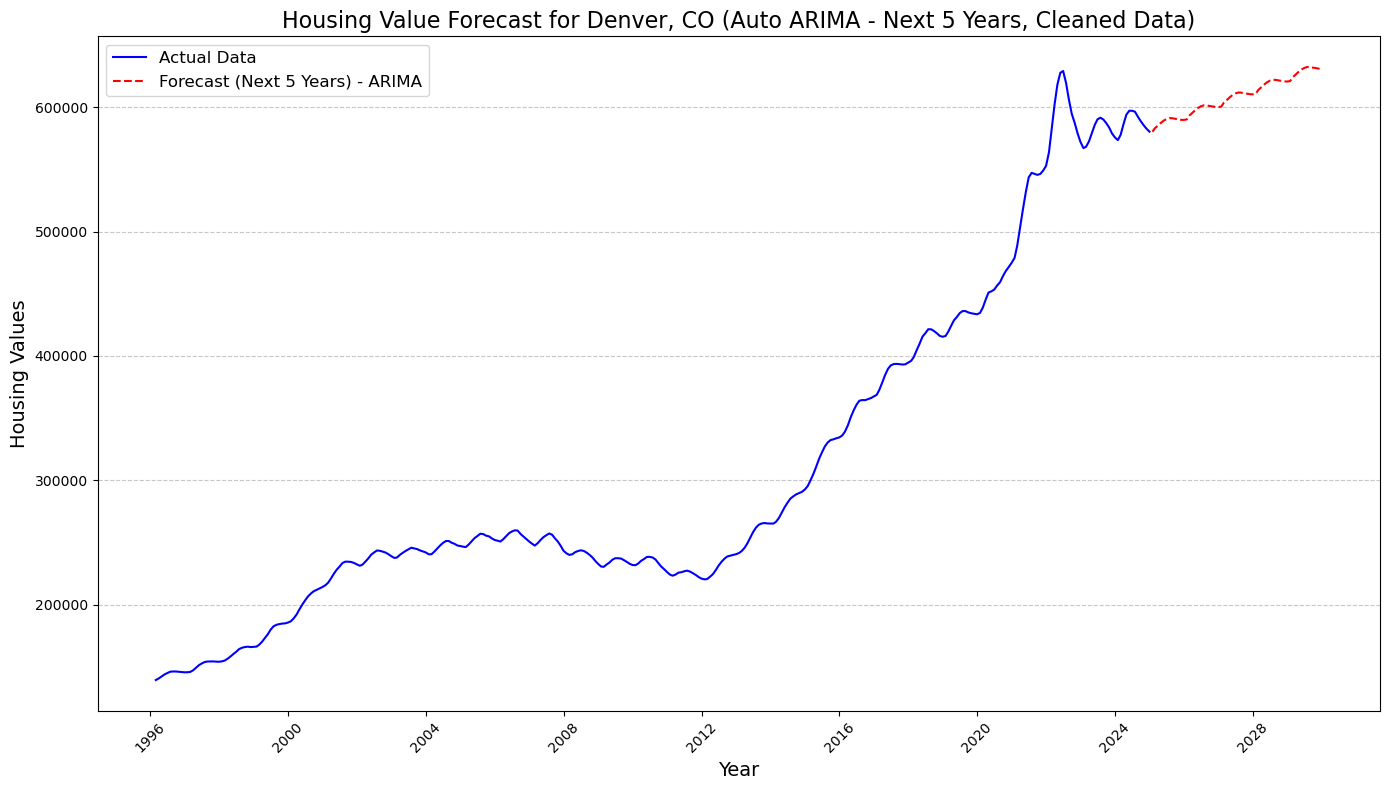

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7075.644, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6679.296, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6622.505, Time=0.39 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6624.295, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6733.007, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=6642.628, Time=0.10 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=6612.705, Time=0.90 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=6593.226, Time=1.20 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=6591.707, Time=0.68 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=6627.900, Time=0.33 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=6593.267, Time=1.22 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=6620.524, Time=0.71 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.96 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=6657.954, Time=0.16 sec
 ARIMA(2,1,0)(1,0,1)[12]

C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\AppData\Local\Temp\ipykernel_34304\1133722841.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=city_forecast_data.index[-1], periods=periods + 1, freq='M')[1:]


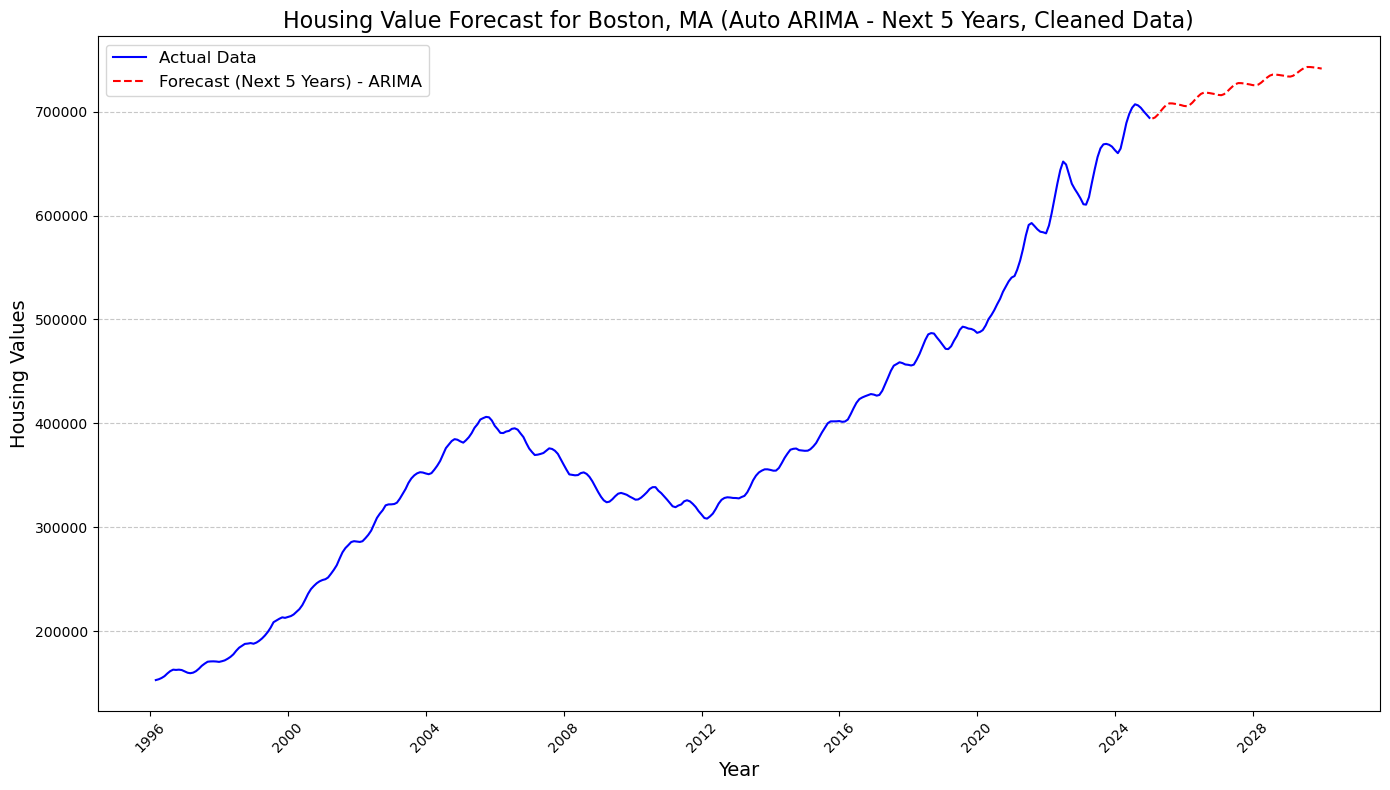

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6740.375, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6688.422, Time=0.40 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6695.462, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6752.178, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=6696.124, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=6690.079, Time=0.89 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=6688.114, Time=0.57 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=6689.096, Time=0.34 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=6690.604, Time=0.90 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=6732.187, Time=0.15 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : 

C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nikhi\AppData\Local\Temp\ipykernel_34304\1133722841.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME'

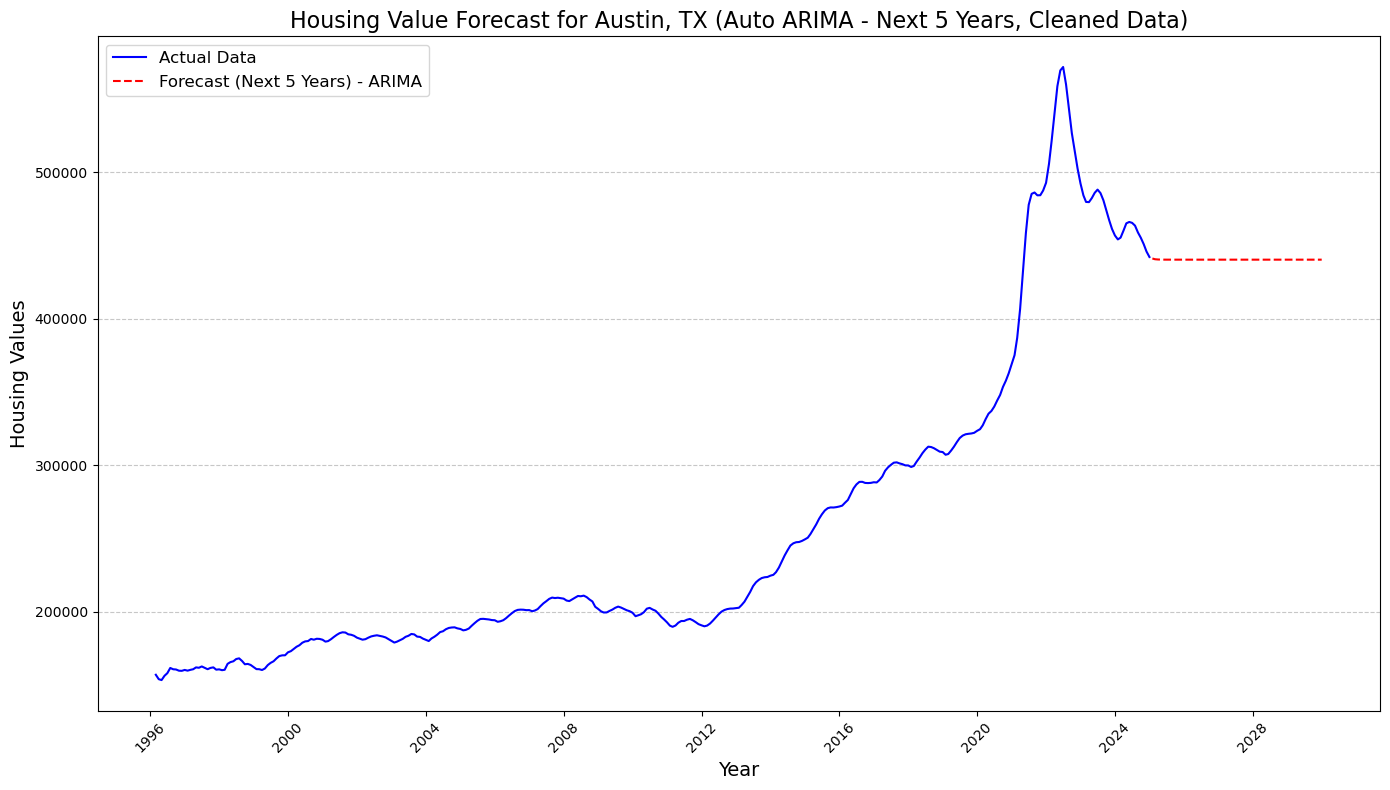

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7671.109, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7549.935, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7528.962, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7690.138, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=7535.246, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=7522.708, Time=0.45 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=7526.290, Time=0.19 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=7517.249, Time=1.00 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=7517.143, Time=0.61 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=7635.441, Time=0.19 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=7537.474, Time=0.48 sec
 ARIMA(0,1,2)(2,0,0)[12] intercept   : AIC=7479.087, Time=0.81 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=7490.447, Time=0.36 sec
 ARIMA(0,1,2)(2,0,1)[12]

C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\AppData\Local\Temp\ipykernel_34304\1133722841.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=city_forecast_data.index[-1], periods=periods + 1, freq='M')[1:]


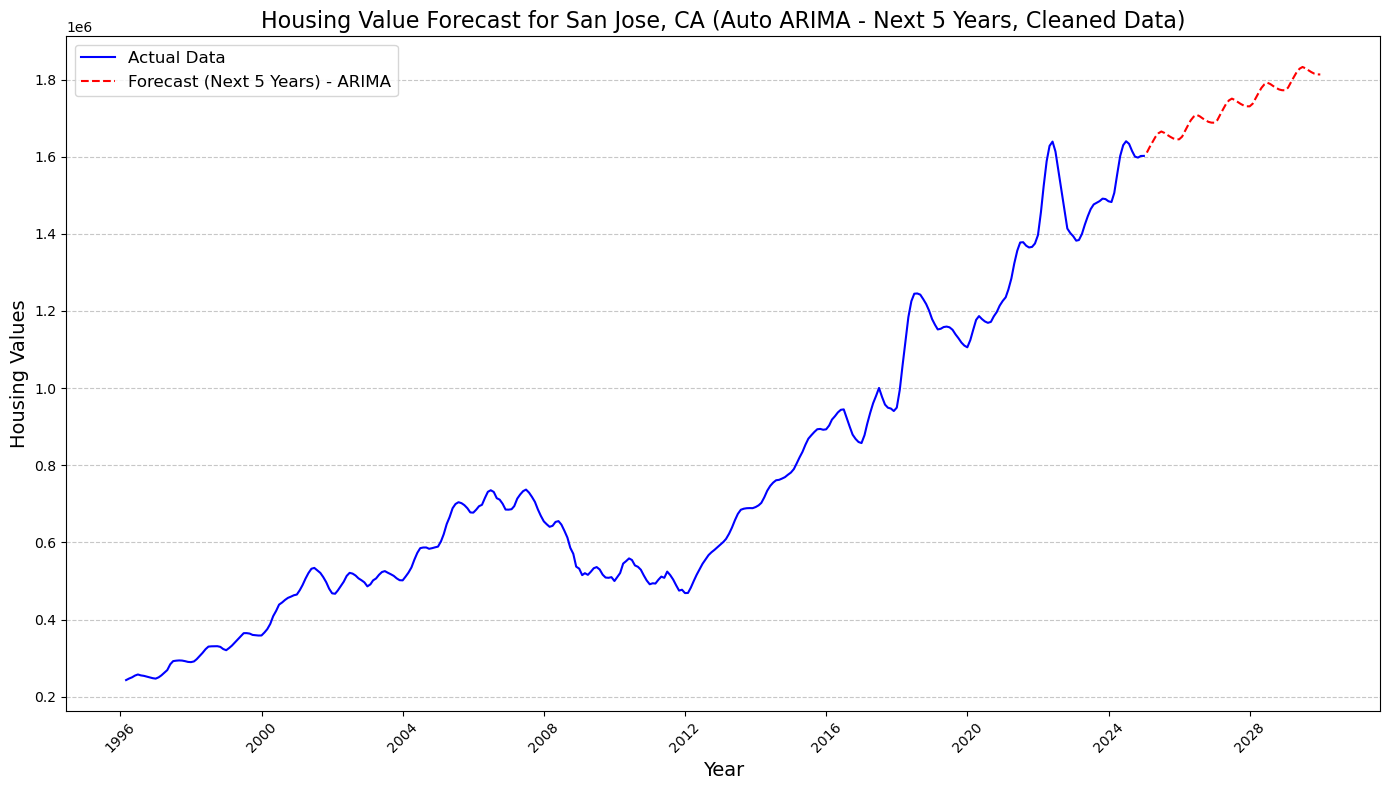

In [24]:
import pmdarima as pm
# Filter the data for the four selected cities
selected_cities = ["Denver, CO", "Boston, MA", "Austin, TX", "San Jose, CA"]
city_data = data[data["RegionName"].isin(selected_cities)]

# Extract time series columns (assuming first 5 columns are metadata)
time_series_columns = data.columns[5:]
city_trends = city_data[["RegionName"] + list(time_series_columns)].set_index("RegionName").T
city_trends.index = pd.to_datetime(city_trends.index)

# Fix outlier in San Jose
san_jose_data = city_trends["San Jose, CA"].copy()
san_jose_diff = san_jose_data.diff()

# Define an outlier threshold (3 standard deviations below the mean)
outlier_threshold = san_jose_diff.mean() - (3 * san_jose_diff.std())

# Identify outliers
outliers = san_jose_diff[san_jose_diff < outlier_threshold].dropna()

# Remove outliers using interpolation
san_jose_data.loc[outliers.index] = None  # Set outliers to NaN
san_jose_data = san_jose_data.interpolate(method="linear")  # Apply linear interpolation

# Update city trends with cleaned San Jose data
city_trends["San Jose, CA"] = san_jose_data

# Define a function to forecast using Auto ARIMA with cleaned data
def forecast_housing_values_arima(city_name, periods=5 * 12):  # Forecast for 5 years (monthly data)
    city_forecast_data = city_trends[city_name].dropna()

    # Convert index to datetime format
    city_forecast_data.index = pd.to_datetime(city_forecast_data.index)

    # Fit Auto ARIMA model with optimized parameters
    auto_arima_model = pm.auto_arima(
        city_forecast_data, 
        seasonal=True, 
        m=12, 
        trace=True, 
        suppress_warnings=True,
        stepwise=True  # Uses a faster stepwise algorithm
    )
    
    # Fit the best ARIMA model
    arima_model = ARIMA(city_forecast_data, order=auto_arima_model.order, seasonal_order=auto_arima_model.seasonal_order)
    fitted_arima = arima_model.fit()

    # Generate forecast for the next 5 years
    forecast_index = pd.date_range(start=city_forecast_data.index[-1], periods=periods + 1, freq='M')[1:]
    forecast_values = fitted_arima.forecast(steps=periods)

    # Plot the actual values and forecasted values
    plt.figure(figsize=(14, 8))
    plt.plot(city_forecast_data.index, city_forecast_data, label="Actual Data", color="blue")
    plt.plot(forecast_index, forecast_values, label="Forecast (Next 5 Years) - ARIMA", color="red", linestyle="dashed")

    # Formatting the plot
    plt.title(f"Housing Value Forecast for {city_name} (Auto ARIMA - Next 5 Years, Cleaned Data)", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Housing Values", fontsize=14)
    plt.legend(fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Forecast for each city using Auto ARIMA with cleaned data
for city in selected_cities:
    forecast_housing_values_arima(city)


C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\AppData\Local\Temp\ipykernel_34304\1556919317.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=city_forecast_data.index[-1], periods=forecast_periods + 1, freq='M')[1:]
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No fre

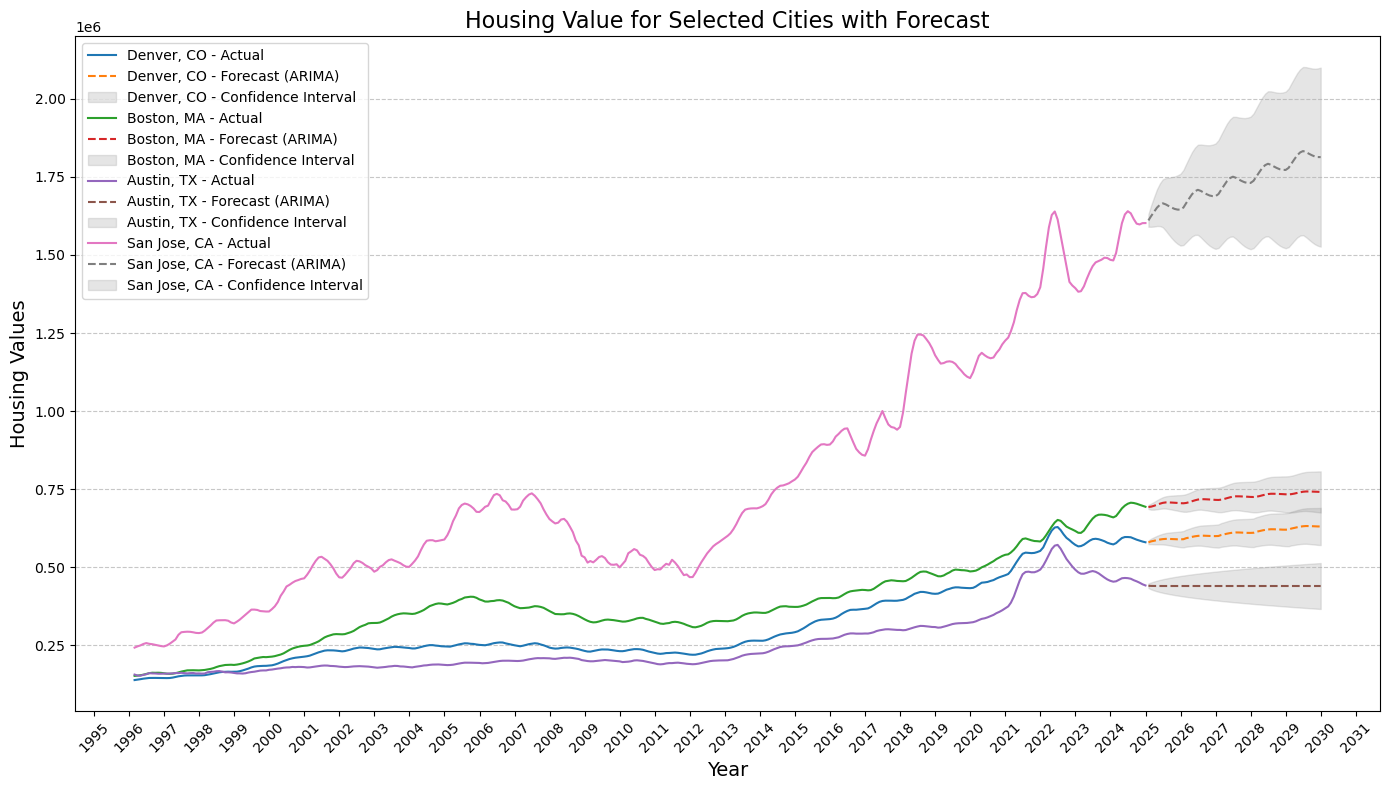

In [30]:
# Filter the data for the four selected cities
selected_cities = ["Denver, CO", "Boston, MA", "Austin, TX", "San Jose, CA"]
city_data = data[data["RegionName"].isin(selected_cities)]

# Extract time series columns (assuming first 5 columns are metadata)
time_series_columns = data.columns[5:]
city_trends = city_data[["RegionName"] + list(time_series_columns)].set_index("RegionName").T
city_trends.index = pd.to_datetime(city_trends.index)

# Fix outlier in San Jose
san_jose_data = city_trends["San Jose, CA"].copy()
san_jose_diff = san_jose_data.diff()

# Define an outlier threshold (3 standard deviations below the mean)
outlier_threshold = san_jose_diff.mean() - (3 * san_jose_diff.std())

# Identify outliers
outliers = san_jose_diff[san_jose_diff < outlier_threshold].dropna()

# Remove outliers using interpolation
san_jose_data.loc[outliers.index] = None  # Set outliers to NaN
san_jose_data = san_jose_data.interpolate(method="linear")  # Apply linear interpolation

# Update city trends with cleaned San Jose data
city_trends["San Jose, CA"] = san_jose_data

# Create a plot to visualize all forecasts together with confidence intervals
plt.figure(figsize=(14, 8))

# Loop through each city and apply Auto ARIMA forecasting
for city in selected_cities:
    city_forecast_data = city_trends[city].dropna()

    # Convert index to datetime format
    city_forecast_data.index = pd.to_datetime(city_forecast_data.index)

    # Fit Auto ARIMA model
    auto_arima_model = pm.auto_arima(
        city_forecast_data, 
        seasonal=True, 
        m=12, 
        trace=False, 
        suppress_warnings=True,
        stepwise=True
    )
    
    # Fit the best ARIMA model
    arima_model = ARIMA(city_forecast_data, order=auto_arima_model.order, seasonal_order=auto_arima_model.seasonal_order)
    fitted_arima = arima_model.fit()

    # Generate forecast for the next 5 years with confidence intervals
    forecast_periods = 5 * 12  # 5 years * 12 months
    forecast_index = pd.date_range(start=city_forecast_data.index[-1], periods=forecast_periods + 1, freq='M')[1:]
    forecast_results = fitted_arima.get_forecast(steps=forecast_periods)
    forecast_values = forecast_results.predicted_mean
    conf_int = forecast_results.conf_int()

    # Plot actual data
    plt.plot(city_forecast_data.index, city_forecast_data, label=f"{city} - Actual", linestyle="solid")

    # Plot forecasted values
    plt.plot(forecast_index, forecast_values, linestyle="dashed", label=f"{city} - Forecast (ARIMA)")

    # Plot confidence intervals
    plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label=f"{city} - Confidence Interval")

# Formatting the plot
plt.title("Housing Value for Selected Cities with Forecast", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Housing Values", fontsize=14)
plt.legend(fontsize=10, loc='upper left')

# Format x-axis for proper year display
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Show every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as YYYY

plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.savefig('zillow_assignment_graph.png',dpi=300)

# Show the combined plot
plt.show()


# Conclusion

### San Jose, CA

- **Historical Trends (1996-2024):**
  - Housing prices grew from approximately $230,000 in 1996 to over $1.6 million in 2024, marking a **600%+ increase** over the period.
  - The strongest growth occurred between **2012 and 2018**, driven by the **tech boom** and **limited housing supply**.
  - The **2008 financial crisis caused a temporary dip (~20%)**, but the market rebounded quickly due to high demand from tech professionals.
  - From **2020 to 2022**, prices surged by nearly **25%**, fueled by pandemic-era demand and low inventory.
- **Forecast (2024-2029):**
  - Prices are projected to increase by another **12-15%** over the next five years, exceeding **$1.8 million by 2029**.
  - Growth will slow compared to the previous decade, as affordability concerns and higher interest rates moderate demand.
  - Despite recent volatility, San Jose remains **the most stable market** due to its robust tech-driven economy and limited housing inventory.

---

### Boston, MA

- **Historical Trends (1996-2024):**
  - Housing prices grew from around **$150,000 in 1996**, to nearly **$700,000 in 2024**, marking a **360% increase** over the period.
  - Significant growth occurred between **2010 and 2020**, driven by the **biotech sector**, **urban development**, and demand for housing near universities.
  - During the pandemic (2020-2024), prices increased by around **15%**, though growth began slowing in 2023-2024 due to rising mortgage rates.
  - The **2008 recession caused a slight decline (~5%)**, but recovery was strong by 2012.

- **Forecast (2024-2029):**
  - Prices are expected to rise by **7-10%**, reaching **$750,000-$800,000 by 2029**.
  - Growth will moderate compared to earlier periods, reflecting a **stabilizing market**.
  - Boston’s strong job market and high-income buyers will sustain demand, but economic uncertainty and affordability will cap further rapid increases.

---

### Denver, CO

- **Historical Trends (1996-2024):**
  - Prices rose from approximately **$130,000 in 1996** to **$600,000 in 2024**, reflecting a **360% increase** over the period.
  - The most dramatic growth occurred between **2012 and 2020**, with prices increasing by **~90%** during this time due to job growth, migration, and relative affordability compared to coastal cities.
  - From **2020 to 2024**, prices increased by **15%**, driven by pandemic demand, but growth began leveling off in 2023-2024 as rising interest rates impacted affordability.
  - The market has shown signs of plateauing, with price growth slowing to nearly **0% in late 2023**.

- **Forecast (2024-2029):**
  - Prices are expected to plateau, growing only by **2-5%** over the next five years, stabilizing between **$600,000-$650,000**.
  - Denver’s affordability issues and increased housing supply are likely to temper further price increases.
  - Migration trends may support demand, but the market will no longer see the explosive growth of the past decade.

---

### Austin, TX

- **Historical Trends (1996-2024):**
  - Prices grew from about **$120,000 in 1996** to **$550,000 in 2024**, marking a **360%+ increase** over the period.
  - The sharpest growth occurred post-2015, with prices increasing by over **150% between 2015 and 2022**, as Austin transformed into a **tech hub** and migration destination.
  - From **2020 to 2022**, prices surged by **30%**, driven by pandemic-era demand from remote workers and the city’s business-friendly reputation.
  - However, growth slowed significantly in 2023-2024, and prices began to decline slightly as inventory increased and demand softened.

- **Forecast (2024-2029):**
  - Austin’s market is projected to decline by **5-10%**, with prices likely falling to **$450,000-$500,000 by 2029**.
  - Oversupply and waning demand post-pandemic are expected to drive the correction.
  - Among the four cities, Austin faces the **highest risk of a downturn**, reflecting its rapid over-expansion during the pandemic years.

---

### Conclusion

- **San Jose**: Prices grew **600%+ (1996-2024)**, saw a **30-40% drop in 2023**, but are forecasted to rise another **12-15% (2024-2029)**, remaining volatile but resilient.
- **Boston**: Prices increased by **360% (1996-2024)** and are expected to grow **7-10% (2024-2029)**, showing moderate but steady growth.
- **Denver**: Prices rose **360% (1996-2024)** but will likely **plateau, with only 2-5% growth** over the next five years.
- **Austin**: Prices increased **360%+ (1996-2024)** but are projected to **decline by 5-10% (2024-2029)** due to oversupply and market cooling.

San Jose remains the **most robust market**, but its **recent volatility highlights its sensitivity to economic conditions**. Austin is the **most vulnerable to price corrections**, while Denver and Boston represent **moderate, stable options** with limited risk but slower growth.
